# Classification using pytorch

In this exercise we will use pytorch to perform a 2-classes classification exercice. For this we will first implement the logistic regression method and observe that it performs rather poorly. Then we will implement a simple neural network and show that the classification can be greatly improved.

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

print('Run on cpu')
dtype = torch.FloatTensor
device = torch.device("cpu")

# fix random generators seed for reproducibility
torch.manual_seed(42)
np.random.seed(seed=42)

Run on cpu


# 1. Generation of the samples

Just run the few cells below to generate the two classes: a 'background' sample and a 'signal' sample.

In [2]:
Nsample = 10000 # Number of events in each sample
features=["x0","x1","x2","x3","x4","x5"] # feature names

In [3]:
# Generation of background sample
# The first 5 features are samples from a multi-dimensional gaussian function. 
# The 6-th feature is constructed from the 5 others.

covMatrix = np.array([[ 0.81652219,  0.12798401,  0.25894314, -0.65065863,  1.24887103],
       [ 0.12798401,  0.90369306, -0.0297507 , -0.27944877,  2.31268408],
       [ 0.25894314, -0.0297507 ,  1.27407394,  0.5200441 , -0.0738098 ],
       [-0.65065863, -0.27944877,  0.5200441 , 19.43674212, -5.04547895],
       [ 1.24887103,  2.31268408, -0.0738098 , -5.04547895, 23.93837133]])

Nvar = 5
mean = np.random.randn(Nvar)
cov = covMatrix
x = np.random.multivariate_normal(mean, cov, Nsample)

# 6-th feature
m = np.sqrt(np.sum(x**2,axis=1))
m = m.reshape(Nsample,1)

# Put sample in a panda dataframe
data = np.concatenate((x,m),axis=1)
background = pd.DataFrame(data,columns=features)

In [4]:
# Now we generate the signal sample
# We use a custom function from scikit-learn that generates 'blobs' of data

from sklearn.datasets import make_blobs
centers = [[0,2,-2,0,0,6]] # center of the blobs
X, y = make_blobs(n_samples=Nsample, cluster_std=2.5, centers=centers, n_features=6, random_state=40)

signal = pd.DataFrame(X,columns=features)

In [5]:
# Here we add a column of label to each sample: 0=background, 1=signal

z=pd.DataFrame(np.zeros(len(background)))
background["label"]=pd.DataFrame(z)

o=pd.DataFrame(np.ones(len(signal)))
signal["label"]=pd.DataFrame(o)

## 2. Data exploration

a) Make histograms of each features for both classes

b) Look at how the features are correlated, for both classes

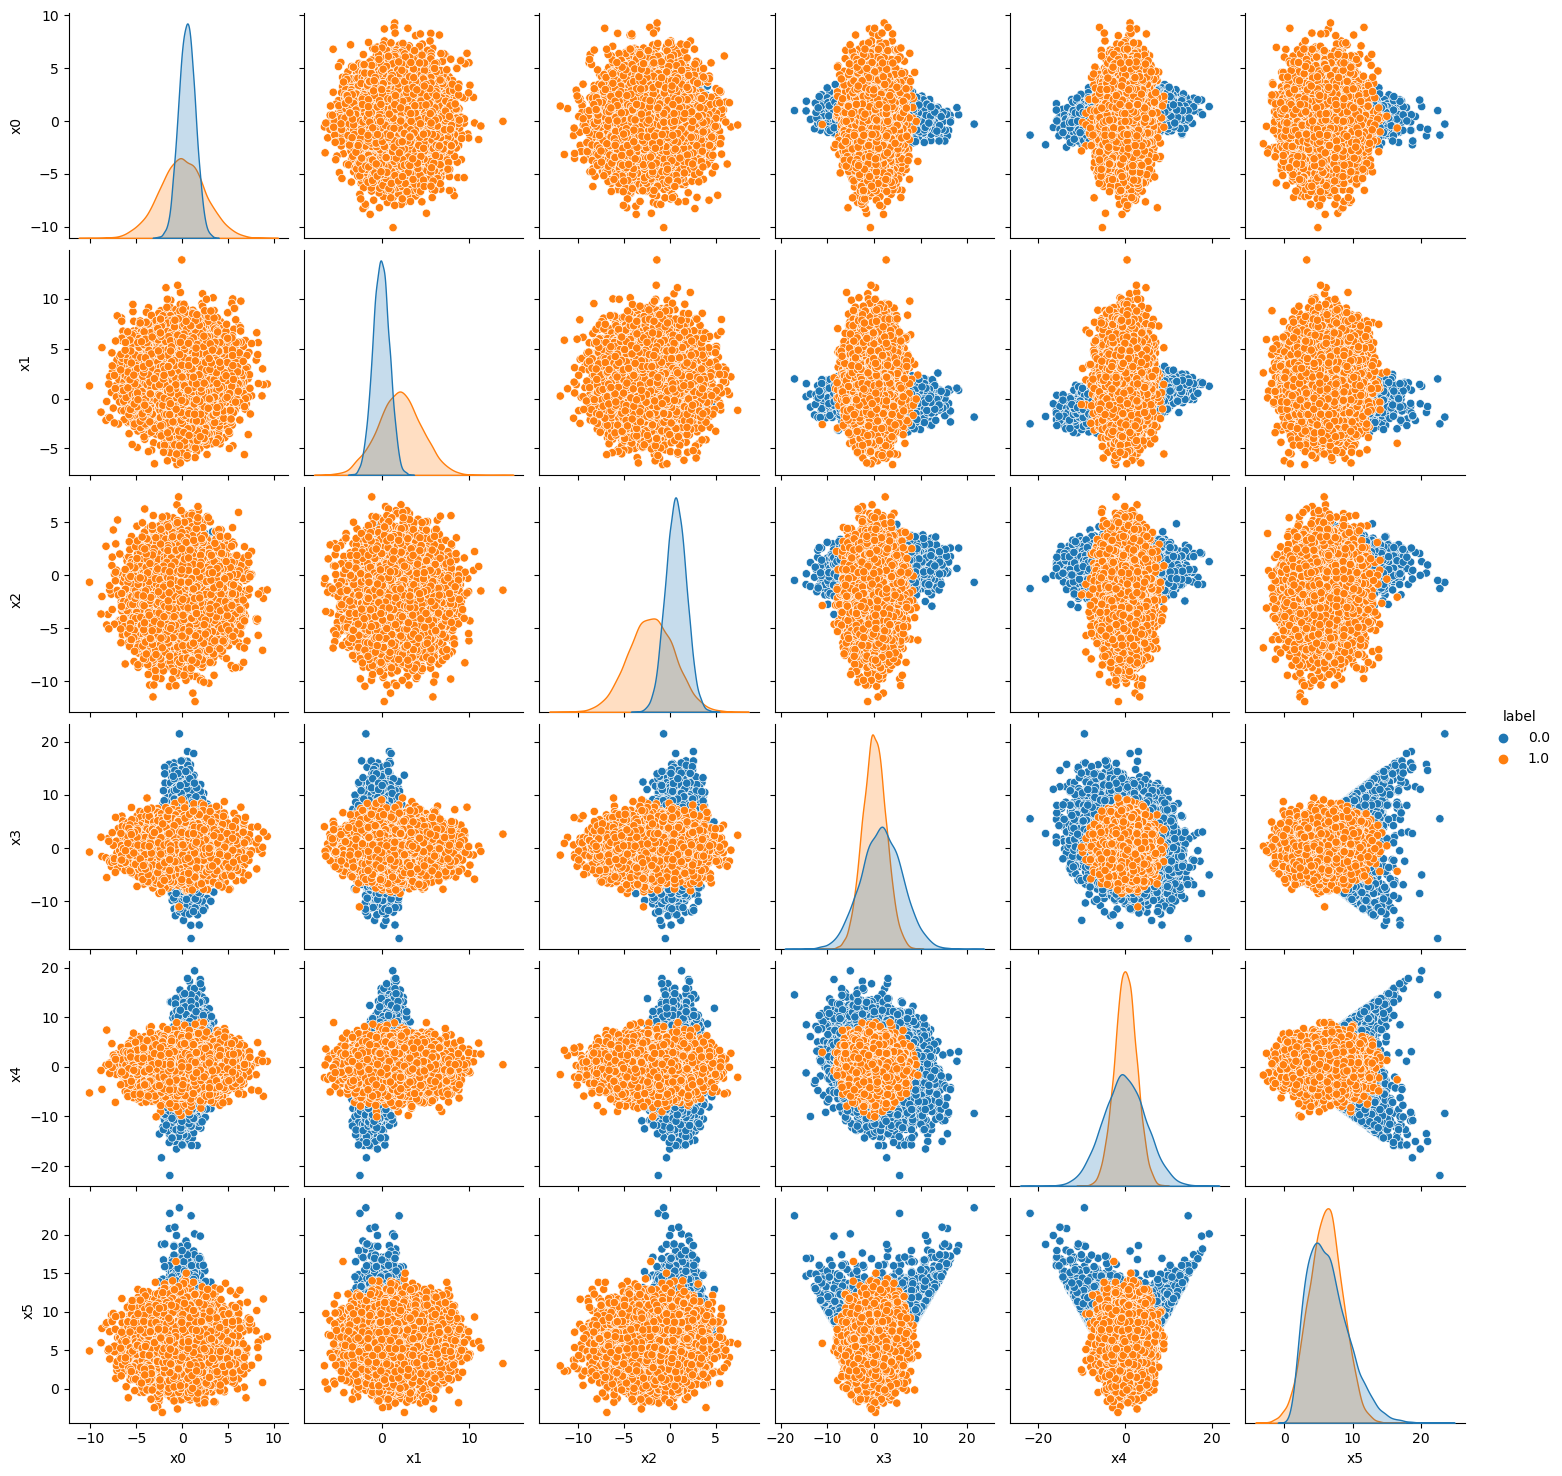

In [6]:
# A convenient way is to use seaborn method
sns.pairplot(pd.concat([background,signal]),hue = 'label')

# 3. Prepare the data for pytorch

First we separate each sample in three data sets: train, validation and test, with fractions 40%, 20%, 40% respectively.

Then we feed these datasets to the DataLoader utility that is quite helpful to split the data in batches in view of the training.

Just run the two cells below.

In [7]:
# Separate train, validation and test data (40,20,40)

x_background_train,x_background_test = train_test_split(background.values,test_size=0.4) 
x_background_train_train,x_background_train_valid = train_test_split(x_background_train,test_size=0.33) 

x_signal_train,x_signal_test = train_test_split(signal.values,test_size=0.4) 
x_signal_train_train,x_signal_train_valid = train_test_split(x_signal_train,test_size=0.33) 

In [8]:
# Data loader

batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_train,x_signal_train_train)),
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_train_valid,x_signal_train_valid)),
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=np.concatenate((x_background_test,x_signal_test)),
                                          batch_size=batch_size,
                                          shuffle=False)


# 4. Build models

1) Construct a first model class that implements the logistic regression method.
- input layer (6 nodes)
- output layer (1 node)
- Sigmoid activation function

2) Construct another model class that implements a simple MLP with the following structure:
- input layer (6 nodes)
- hidden layer with 200 nodes
- ReLU activation function
- output layer (1 node)
- Sigmoid activation function

As an example you can look this page: https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

In [9]:
input_dim, hidden_dim, output_dim = 6, 200, 1

In [10]:
# Logistic regression
class LogRegression(nn.Module):
    def __init__(self, D_in, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LogRegression, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = torch.sigmoid(self.linear1(x))
        return x

LogReg = LogRegression(input_dim,output_dim)

In [11]:
# MLP with one hidden layer
class MLP(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(MLP, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x = torch.relu(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

NN = MLP(input_dim, hidden_dim, output_dim) 

# 5. Train model with Logistic regression

After choosing some setting for the training run the training on your model (either the Log regr ot the MLP)

a) Complete the cell below.

b) Modify the code to store values of train and validation loss values at each epoch

c) Run the training and make a plot of the loss values for the training and validation steps

In [12]:
# Training settings

# Choose model
model = LogReg
#model = NN

# Choose number of epochs
num_epochs = 50

# Binary Cross Entropy loss function
criterion = nn.BCELoss() 

# Optimisation model, here we choose Adam which is stochastic gradient descent with improvements
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5) 

In [13]:
# Track the training and validation loss as the model trains
train_loss = []
valid_loss = []
# Track the average training and validation loss per epoch as the model trains
avg_train_loss = []
avg_valid_loss = [] 

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        # ===================forward=====================
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record validation loss
        train_loss.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # record validation loss
        valid_loss.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_losses = np.average(train_loss)
    valid_losses = np.average(valid_loss)
    avg_train_loss.append(train_losses)
    avg_valid_loss.append(valid_losses)
    epoch_len = len(str(num_epochs))

    print_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_losses:.5f} ' +
                 f'valid_loss: {valid_losses:.5f}')

    if (epoch==0 or (epoch+1)%100==0):
        #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        print(print_msg)

    # clear lists to track next epoch
    train_loss = []
    valid_loss = []

#print('Final loss value: %.4f' % train_loss[-1])


[ 1/50] train_loss: 0.92144 valid_loss: 0.80279


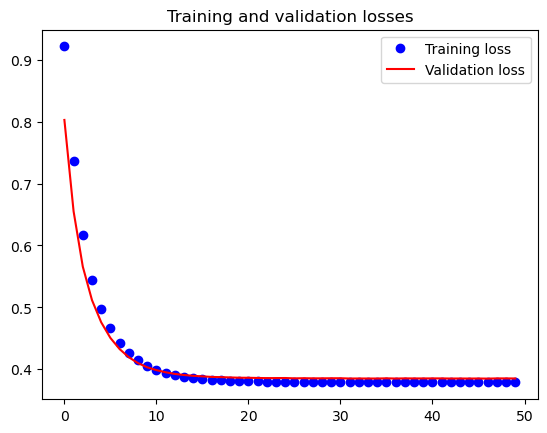

In [14]:
# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, avg_train_loss, 'bo', label='Training loss')
plt.plot(epochs, avg_valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

# 6. Test phase and results

For both models (logistic regression then MLP)

a) Apply the trained model to test samples

b) Show the histograms of the model output for both background and signal samples. 

c) Display the confusion matrix (threshold = 0.5)

d) Show the ROC curve

e) Conclusions: Is the separation satisfactory for the case of the logistic regression ? What about the performance for the MLP ?


## Output values for train and test samples

In [15]:
train_out  = []
train_target = []

for data in train_loader:
    data = data.type(dtype)
    output = model(data[:,0:input_dim])
    target = data[:,input_dim]
    train_out    += [output]
    train_target += [target]

train_out    = torch.cat(train_out).cpu().detach().numpy()
train_target = torch.cat(train_target).cpu().detach().numpy()

test_out  = []
test_target = []

for data in test_loader:
    data = data.type(dtype)
    output = model(data[:,0:input_dim])
    target = data[:,input_dim]
    test_out  += [output]
    test_target += [target]

test_out    = torch.cat(test_out).cpu().detach().numpy()
test_target = torch.cat(test_target).cpu().detach().numpy()

## Plots

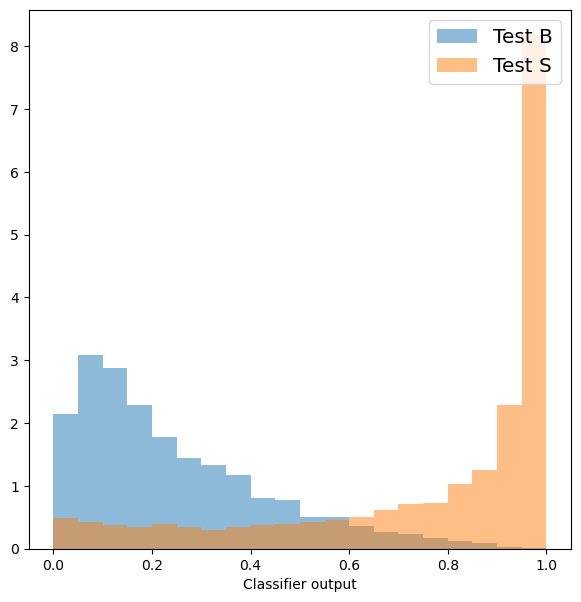

In [16]:
"""
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(train_out[train_target==0], range=(0,1), bins=20, alpha=0.5, label='Train B', density=1)
plt.hist(train_out[train_target==1], bins, alpha=0.5, label='Train S', density=1)
plt.xlabel('Classifier output')
plt.legend(loc='upper right',fontsize='x-large')
"""

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(test_out[test_target==0], range=(0,1), bins=20, alpha=0.5, label='Test B', density=1)
plt.hist(test_out[test_target==1], bins, alpha=0.5, label='Test S', density=1)
plt.xlabel('Classifier output')
plt.legend(loc='upper right',fontsize='x-large')

## Confusion matrix

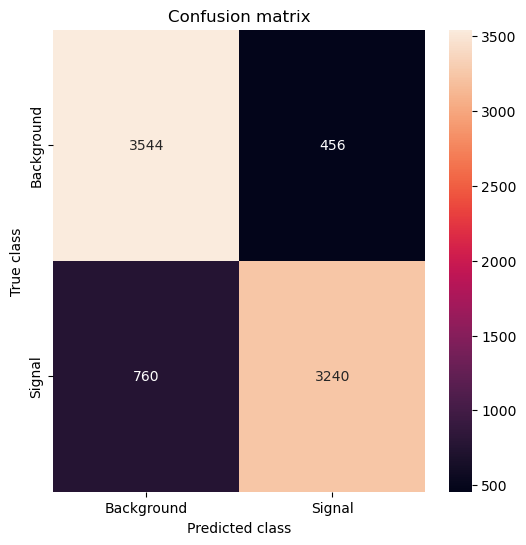

False positive rate = 11.40 %
True positive rate = 81.00 %


In [17]:
from sklearn.metrics import confusion_matrix

LABELS = ["Background", "Signal"]

threshold = 0.5

y_pred = [1 if e > threshold else 0 for e in test_out]
conf_matrix = confusion_matrix(test_target, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

TN = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
TP = conf_matrix[1,1]
print('False positive rate = %.2f %%' % (FP/(FP+TN)*100))
print('True positive rate = %.2f %%' % (TP/(TP+FN)*100))


## ROC curve

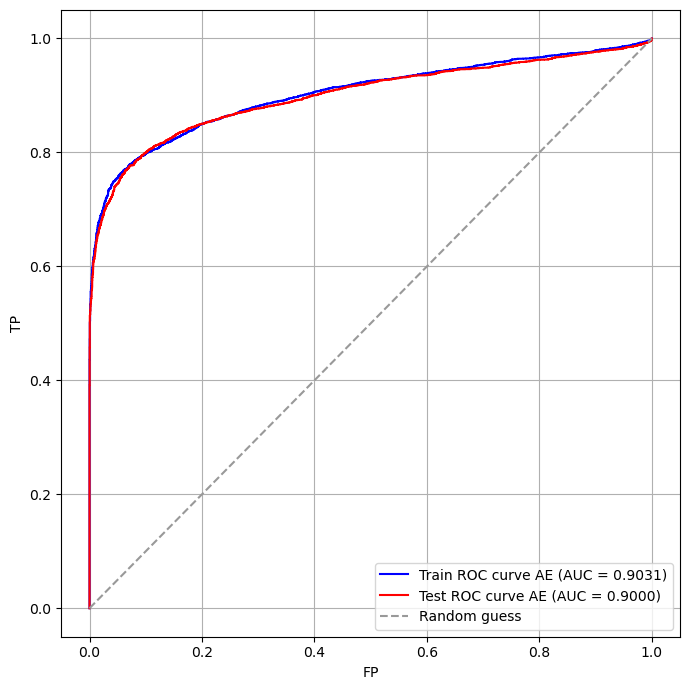

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

plt.figure(figsize=(7, 7))

fp0, vp0, thresholds0 = roc_curve(train_target,train_out,pos_label=1)
roc_auc0 = auc(fp0, vp0)

fp1, vp1, thresholds1 = roc_curve(test_target,test_out,pos_label=1)
roc_auc1 = auc(fp1, vp1)

plt.plot(fp0,vp0,color='blue',label='Train ROC curve %s (AUC = %0.4f)'%('AE',roc_auc0))

plt.plot(fp1,vp1,color='red',label='Test ROC curve %s (AUC = %0.4f)'%('AE',roc_auc1))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/ROC.png")

# 7. Train model with the Neural network

After choosing some setting for the training run the training on your model (either the Log regr ot the MLP)

a) Complete the cell below.

b) Modify the code to store values of train and validation loss values at each epoch

c) Run the training and make a plot of the loss values for the training and validation steps

In [19]:
# Training settings

# Choose model
model = NN

# Choose number of epochs
num_epochs = 50

# Binary Cross Entropy loss function
criterion = nn.BCELoss() 

# Optimisation model, here we choose Adam which is stochastic gradient descent with improvements
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay = 1e-5) 

In [20]:
# Track the training and validation loss as the model trains
train_loss = []
valid_loss = []
# Track the average training and validation loss per epoch as the model trains
avg_train_loss = []
avg_valid_loss = [] 

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        # ===================forward=====================
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # record validation loss
        train_loss.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data[:,0:input_dim])[:,0]
        target = data[:,input_dim]
        loss = criterion(output, target)
        # record validation loss
        valid_loss.append(loss.item())

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_losses = np.average(train_loss)
    valid_losses = np.average(valid_loss)
    avg_train_loss.append(train_losses)
    avg_valid_loss.append(valid_losses)
    epoch_len = len(str(num_epochs))

    print_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
                 f'train_loss: {train_losses:.5f} ' +
                 f'valid_loss: {valid_losses:.5f}')

    if (epoch==0 or (epoch+1)%100==0):
        #print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
        print(print_msg)

    # clear lists to track next epoch
    train_loss = []
    valid_loss = []

#print('Final loss value: %.4f' % train_loss[-1])


[ 1/50] train_loss: 0.46344 valid_loss: 0.31664


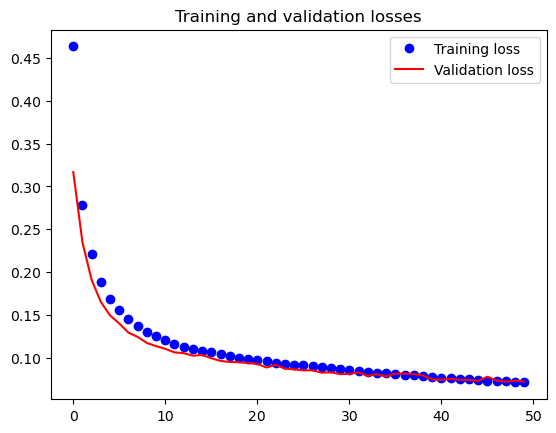

In [21]:
# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, avg_train_loss, 'bo', label='Training loss')
plt.plot(epochs, avg_valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()
plt.show()

# Test phase and results

For both models (logistic regression then MLP)

a) Apply the trained model to test samples

b) Show the histograms of the model output for both background and signal samples. 

c) Display the confusion matrix (threshold = 0.5)

d) Show the ROC curve

e) Conclusions: Is the separation satisfactory for the case of the logistic regression ? What about the performance for the MLP ?


## Output values for train and test samples

In [22]:
train_out  = []
train_target = []

for data in train_loader:
    data = data.type(dtype)
    output = model(data[:,0:input_dim])
    target = data[:,input_dim]
    train_out    += [output]
    train_target += [target]

train_out    = torch.cat(train_out).cpu().detach().numpy()
train_target = torch.cat(train_target).cpu().detach().numpy()

test_out  = []
test_target = []

for data in test_loader:
    data = data.type(dtype)
    output = model(data[:,0:input_dim])
    target = data[:,input_dim]
    test_out  += [output]
    test_target += [target]

test_out    = torch.cat(test_out).cpu().detach().numpy()
test_target = torch.cat(test_target).cpu().detach().numpy()

## Plots

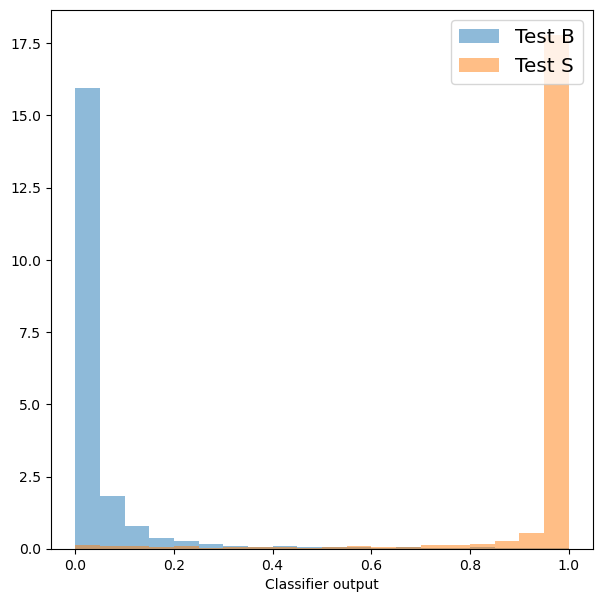

In [23]:
"""
plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(train_out[train_target==0], range=(0,1), bins=20, alpha=0.5, label='Train B', density=1)
plt.hist(train_out[train_target==1], bins, alpha=0.5, label='Train S', density=1)
plt.xlabel('Classifier output')
plt.legend(loc='upper right',fontsize='x-large')
"""

plt.figure(figsize=(7, 7))
n, bins, patches = plt.hist(test_out[test_target==0], range=(0,1), bins=20, alpha=0.5, label='Test B', density=1)
plt.hist(test_out[test_target==1], bins, alpha=0.5, label='Test S', density=1)
plt.xlabel('Classifier output')
plt.legend(loc='upper right',fontsize='x-large')

## Confusion matrix

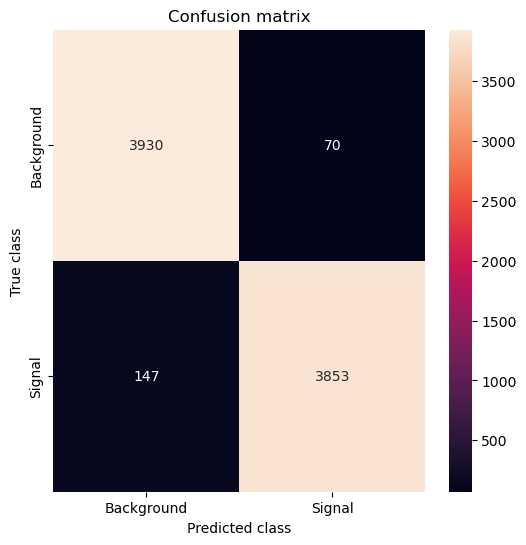

False positive rate = 1.75 %
True positive rate = 96.33 %


In [24]:
from sklearn.metrics import confusion_matrix

LABELS = ["Background", "Signal"]

threshold = 0.5

y_pred = [1 if e > threshold else 0 for e in test_out]
conf_matrix = confusion_matrix(test_target, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

TN = conf_matrix[0,0]
FP = conf_matrix[0,1]
FN = conf_matrix[1,0]
TP = conf_matrix[1,1]
print('False positive rate = %.2f %%' % (FP/(FP+TN)*100))
print('True positive rate = %.2f %%' % (TP/(TP+FN)*100))


## ROC curve

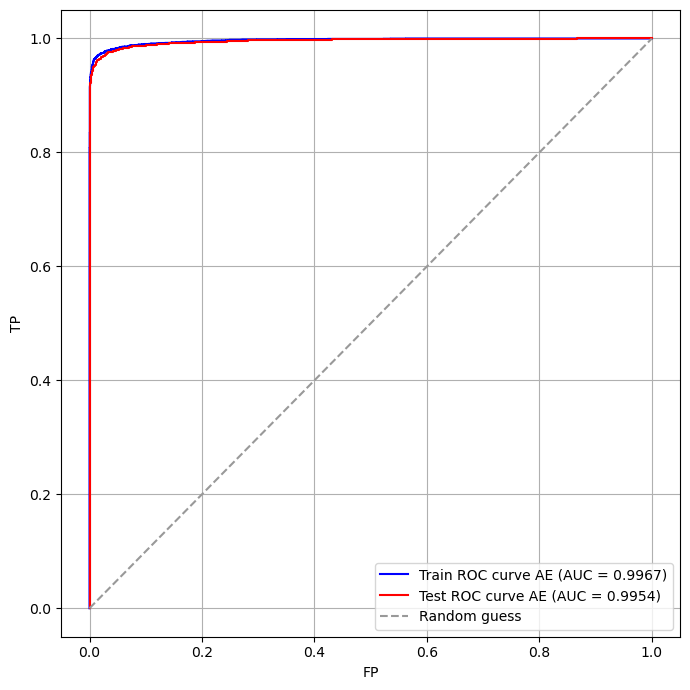

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict

plt.figure(figsize=(7, 7))

fp0, vp0, thresholds0 = roc_curve(train_target,train_out,pos_label=1)
roc_auc0 = auc(fp0, vp0)

fp1, vp1, thresholds1 = roc_curve(test_target,test_out,pos_label=1)
roc_auc1 = auc(fp1, vp1)

plt.plot(fp0,vp0,color='blue',label='Train ROC curve %s (AUC = %0.4f)'%('AE',roc_auc0))

plt.plot(fp1,vp1,color='red',label='Test ROC curve %s (AUC = %0.4f)'%('AE',roc_auc1))

plt.xlabel('FP')
plt.ylabel('TP')
plt.plot([0, 1],[0, 1],
         linestyle='--',color=(0.6, 0.6, 0.6),
         label='Random guess')
#plt.plot([0, 0, 1],[0, 1, 1],color='yellow',label='Idéal')
plt.grid()
plt.legend(loc="best")
plt.tight_layout()
plt.savefig("images/ROC.png")